In [1]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [2]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763020 entries, 0 to 1763019
Data columns (total 44 columns):
Status                  category
Sex                     category
Convictions             category
GangMember              category
ClassLvl                float32
Age                     float32
MissionDate             datetime64[ns]
MissionNumber           uint32
PULOC                   category
DropLoc                 category
StrikeFromList          float32
ReasonStruck            category
R-T                     category
Code                    category
CountryOfCitizenship    category
Juvenile                bool
MissionWeek             uint8
MissionQuarter          uint8
MissionYear             uint16
MissionMonth            uint8
Criminality             category
FamilyUnitFlag          float32
UnaccompaniedFlag       float32
AlienMasterID           uint32
MissionID               uint16
air_AirportID           float32
air_AirportName         category
air_City         

# By country of citizenship

In [3]:
nationality = 'MAURITANIA'

In [29]:
if nationality.upper() in df['CountryOfCitizenship'].str.upper().unique():
    pass
else:
    print(f'{nationality} not represented in dataset')

In [32]:
removal_df = df[df['R-T'] == 'R'].drop_duplicates(subset='AlienMasterID')
transfer_df = df[df['R-T'] == 'T'].drop_duplicates(subset='AlienMasterID')

In [33]:
all_nationalities = removal_df.groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique()
all_nationalities = all_nationalities.sort_values(ascending=False)
all_nationalities = all_nationalities.reset_index().reset_index()
all_nationalities['Rank'] = all_nationalities['index'] + 1
all_nationalities.drop('index', axis=1, inplace=True)
all_nationalities[all_nationalities['CountryOfCitizenship'] == nationality]

,CountryOfCitizenship,AlienMasterID,Rank
52,MAURITANIA,12,53


In [34]:
nationality_df = df[df['CountryOfCitizenship'] == nationality.upper()]

In [35]:
# Top pickup airports (removals and transfers)
nationality_df['air_AirportName'].value_counts().head(10)

Alexandria International Airport         48
Toledo Express Airport                   29
Phoenix-Mesa-Gateway Airport             27
Newark Liberty International Airport      9
San Diego International Airport           5
Harrisburg International Airport          3
Laredo International Airport              1
San Antonio International Airport         1
Buffalo Niagara International Airport     1
Columbus Metropolitan Airport             1
Name: air_AirportName, dtype: int64

In [36]:
# Top dropoff airports (removals and transfers)
nationality_df['air2_AirportName'].value_counts().head(10)

Alexandria International Airport                  51
Newark Liberty International Airport              18
Phoenix-Mesa-Gateway Airport                      14
Toledo Express Airport                            12
Nouakchott-Oumtounsy International Airport        12
Denver International Airport                       5
Boeing Field King County International Airport     3
El Paso International Airport                      3
Harrisburg International Airport                   2
Portland International Airport                     2
Name: air2_AirportName, dtype: int64

In [37]:
nationality_df.set_index('MissionDate', inplace=True)

In [38]:
g = nationality_df.groupby(['CountryOfCitizenship', 'MissionDate', 'R-T', 'PULOC', 'DropLoc'])

In [39]:
table = g['AlienMasterID'].nunique().reset_index(name='AlienMasterIDCount')
table['MissionIDCount'] = g['MissionID'].nunique().reset_index(name='MissionIDCount')['MissionIDCount']
table['JuvenileCount'] = g['Juvenile'].sum().reset_index(name='JuvenileCount')['JuvenileCount']
table['JuvPercent'] = table['JuvenileCount'] / table['AlienMasterIDCount']
table['NCCount'] = g['NonCriminal'].sum().reset_index(name='NCCount')['NCCount']
table['NCPercent'] = table['NCCount'] / table['AlienMasterIDCount'] * 100

In [40]:
removals = table[table['R-T'] == 'R'].copy()
transfers = table[table['R-T'] == 'T'].copy()

In [41]:
removals.set_index('MissionDate', inplace=True)
transfers.set_index('MissionDate', inplace=True)

In [42]:
# Total removals
removals['AlienMasterIDCount'].sum()

12

In [43]:
# Total removal flights
removals['MissionIDCount'].sum()

4

In [44]:
# Total transfers
transfers['AlienMasterIDCount'].sum()

116

In [45]:
weekly_removals = removals['AlienMasterIDCount'].resample('W').sum()
weekly_transfers = transfers['AlienMasterIDCount'].resample('W').sum()
monthly_removals = removals['AlienMasterIDCount'].resample('M').sum()
monthly_transfers = transfers['AlienMasterIDCount'].resample('M').sum()
monthly_removal_flights = removals['MissionIDCount'].resample('M').sum()
monthly_transfers_flights = transfers['MissionIDCount'].resample('M').sum()
annual_removals = removals['AlienMasterIDCount'].resample('AS-OCT').sum()
annual_transfers = transfers['AlienMasterIDCount'].resample('AS-OCT').sum()
annual_removal_flights = removals['MissionIDCount'].resample('AS-OCT').sum()
annual_transfer_flights = transfers['MissionIDCount'].resample('AS-OCT').sum()
annual_juvenile_removals = removals['JuvenileCount'].resample('AS-OCT').sum()

In [46]:
annual_removals

MissionDate
2016-10-01    2
2017-10-01    7
2018-10-01    3
Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64

In [47]:
annual_transfers

MissionDate
2010-10-01     1
2011-10-01     1
2012-10-01     0
2013-10-01     0
2014-10-01     0
2015-10-01     3
2016-10-01     8
2017-10-01    89
2018-10-01    14
Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64

In [48]:
annual_juvenile_removals

MissionDate
2016-10-01    False
2017-10-01    False
2018-10-01    False
Freq: AS-OCT, Name: JuvenileCount, dtype: bool

In [49]:
removals.reset_index(inplace=True, drop=False)
transfers.reset_index(inplace=True, drop=False)

In [50]:
removals.tail(20)

,MissionDate,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
0,2016-11-15,MAURITANIA,R,KAEX,GQNO,2,1,False,0.0,0.0,0.000000
1,2018-04-10,MAURITANIA,R,KIWA,GQNO,2,1,False,0.0,1.0,50.000000
2,2018-06-11,MAURITANIA,R,KIWA,GQNO,5,1,False,0.0,2.0,40.000000
3,2018-10-16,MAURITANIA,R,KIWA,GQNO,3,1,False,0.0,2.0,66.666667


In [51]:
removals.to_csv(f'../output/{nationality}_removal_flights.csv')

In [52]:
transfers.head()

,MissionDate,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
0,2010-12-08,MAURITANIA,T,KMDT,KAEX,1,1,False,0.0,0.0,0.0
1,2011-12-05,MAURITANIA,T,KMDT,KAEX,1,1,False,0.0,0.0,0.0
2,2016-04-07,MAURITANIA,T,KIWA,KAEX,1,1,False,0.0,1.0,100.0
3,2016-09-06,MAURITANIA,T,KEWR,KAEX,1,1,False,0.0,0.0,0.0
4,2016-09-07,MAURITANIA,T,KAEX,KTOL,1,1,False,0.0,0.0,0.0


In [53]:
# transfers.to_csv(f'../output/{nationality.lower()}_transfers.csv.gz', compression='gzip', sep='|', index=False)
# removals.to_csv(f'../output/{nationality.lower()}_repatriations.csv.gz', compression='gzip', sep='|', index=False)

In [54]:
removals.set_index('MissionDate', inplace=True)

In [55]:
transfers.set_index('MissionDate', inplace=True)

In [56]:
r_cum = removals['AlienMasterIDCount'].cumsum()
t_cum = transfers['AlienMasterIDCount'].cumsum()

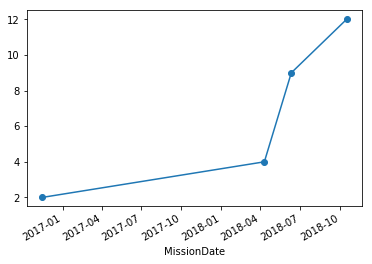

In [57]:
r_cum.plot(style='o-')

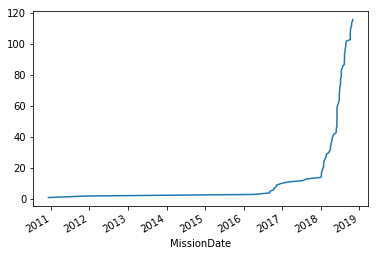

In [58]:
t_cum.plot()

In [59]:
g = nationality_df.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'R-T', 'air_AirportName', 'air2_AirportName', 'air2_Country'])[['AlienMasterID', 'MissionID']].nunique()
g.reset_index(inplace=True)
removal_dropoff_airports = g[g['R-T'] == 'R'].copy()
transfer_dropoff_airports = g[g['R-T'] == 'T'].copy()

In [60]:
removal_dropoff_airports.sort_values(by=['MissionDate', 'AlienMasterID'], ascending=[True, False], inplace=True)
transfer_dropoff_airports.sort_values(by=['MissionDate', 'AlienMasterID'], ascending=[True, False], inplace=True)

In [61]:
removal_dropoff_airports.head()

,MissionDate,R-T,air_AirportName,air2_AirportName,air2_Country,AlienMasterID,MissionID
5,2016-10-01,R,Alexandria International Airport,Nouakchott-Oumtounsy International Airport,Mauritania,2,1
14,2017-10-01,R,Phoenix-Mesa-Gateway Airport,Nouakchott-Oumtounsy International Airport,Mauritania,7,2
29,2018-10-01,R,Phoenix-Mesa-Gateway Airport,Nouakchott-Oumtounsy International Airport,Mauritania,3,1


In [62]:
transfer_dropoff_airports.head(10)

,MissionDate,R-T,air_AirportName,air2_AirportName,air2_Country,AlienMasterID,MissionID
0,2010-10-01,T,Harrisburg International Airport,Alexandria International Airport,USA,1,1
1,2011-10-01,T,Harrisburg International Airport,Alexandria International Airport,USA,1,1
2,2015-10-01,T,Alexandria International Airport,Toledo Express Airport,USA,1,1
3,2015-10-01,T,Phoenix-Mesa-Gateway Airport,Alexandria International Airport,USA,1,1
4,2015-10-01,T,Newark Liberty International Airport,Alexandria International Airport,USA,1,1
6,2016-10-01,T,Alexandria International Airport,Harrisburg International Airport,USA,1,1
7,2016-10-01,T,Columbus Metropolitan Airport,Alexandria International Airport,USA,1,1
8,2016-10-01,T,Laredo International Airport,Youngston Warren Regional Airport,USA,1,1
9,2016-10-01,T,Phoenix-Mesa-Gateway Airport,Alexandria International Airport,USA,1,1
10,2016-10-01,T,Phoenix-Mesa-Gateway Airport,Boeing Field King County International Airport,USA,1,1


In [63]:
# removal_dropoff_airports.to_csv(f'../output/{nationality}_repatriation_dropoff_airports.csv')
# transfer_dropoff_airports.to_csv(f'../output/{nationality}_transfer_dropoff_airports.csv')

In [64]:
removal_dropoff_airports = removal_dropoff_airports.set_index('MissionDate')

In [65]:
removal_sum = removal_dropoff_airports.groupby([pd.Grouper(freq='AS-OCT'), 'air2_AirportName'])[['AlienMasterID']].sum()

In [66]:
removal_sum.reset_index(inplace=True)
removal_sum = removal_sum.sort_values(by=['MissionDate', 'AlienMasterID'], ascending=[True, False])

In [67]:
removal_sum.set_index('MissionDate', inplace=True)

In [68]:
removal_sum = removal_sum.dropna()

In [69]:
top_5_df = pd.DataFrame()

for year in removal_sum.index.unique():
    temp = removal_sum.loc[f'{year}'][['air2_AirportName', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    if len(temp) > 5:
        all_other_count = sum(temp['AlienMasterID'][5:])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]], columns=['air2_AirportName', 'AlienMasterID'], index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)

/home/philneff/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)


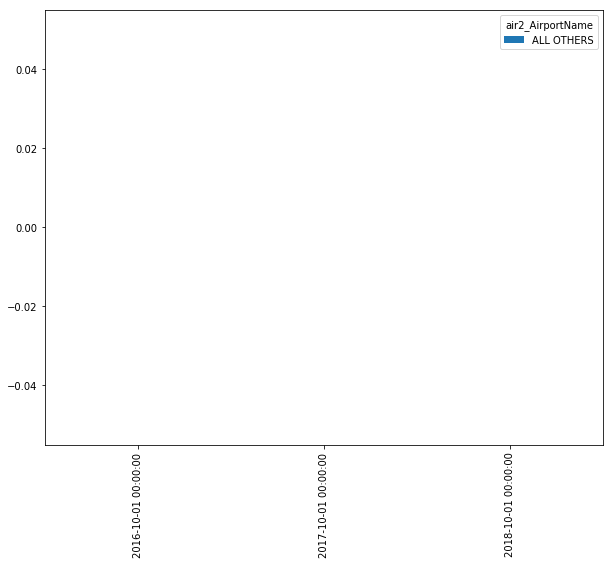

In [70]:
pivot = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='air2_AirportName',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

pivot = pivot.reindex(pivot.sum().sort_values(ascending=False).index, axis=1)
cols = list(pivot.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
pivot = pivot[cols]

fig = pivot.plot(kind='bar', stacked=True, figsize=(10, 8))

## Juveniles only

In [71]:
juv_r_cum = removals['JuvenileCount'].cumsum()

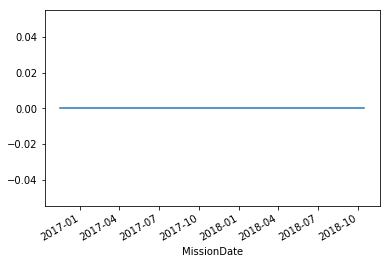

In [72]:
juv_r_cum.plot()

In [73]:
removals.tail(20)

,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
MissionDate,,,,,,,,,,
2016-11-15,MAURITANIA,R,KAEX,GQNO,2,1,False,0.0,0.0,0.000000
2018-04-10,MAURITANIA,R,KIWA,GQNO,2,1,False,0.0,1.0,50.000000
2018-06-11,MAURITANIA,R,KIWA,GQNO,5,1,False,0.0,2.0,40.000000
2018-10-16,MAURITANIA,R,KIWA,GQNO,3,1,False,0.0,2.0,66.666667


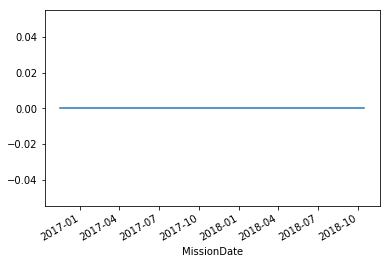

In [74]:
removals['JuvPercent'].plot();

In [75]:
removals[removals['JuvPercent'] > .5]

,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
MissionDate,,,,,,,,,,


In [76]:
transfers['JuvenileCount'].value_counts()

False    77
Name: JuvenileCount, dtype: int64

In [77]:
removals[removals['JuvenileCount'] > 20]

,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
MissionDate,,,,,,,,,,


# KBFI only

In [78]:
airport = 'KBFI'

In [79]:
airport_removals = pd.concat([removals[removals['PULOC'] == airport], removals[removals['DropLoc'] == airport]])

In [80]:
airport_removals

,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
MissionDate,,,,,,,,,,


In [90]:
airport_transfers = pd.concat([transfers[transfers['PULOC'] == airport], transfers[transfers['DropLoc'] == airport]])

In [91]:
airport_transfers.to_csv(f'../output/{nationality}_transfers_tofrom_{airport}.csv')

In [83]:
airport_weekly_removals = airport_removals['AlienMasterIDCount'].resample('W').nunique()
airport_weekly_transfers = airport_transfers['AlienMasterIDCount'].resample('W').nunique()
airport_monthly_removals = airport_removals['AlienMasterIDCount'].resample('M').nunique()
airport_monthly_transfers = airport_transfers['AlienMasterIDCount'].resample('M').nunique()
airport_monthly_removal_flights = airport_removals['MissionIDCount'].resample('M').nunique()
airport_monthly_transfers_flights = airport_transfers['MissionIDCount'].resample('M').nunique()
airport_annual_removals = airport_removals['AlienMasterIDCount'].resample('AS-OCT').nunique()
airport_annual_transfers = airport_transfers['AlienMasterIDCount'].resample('AS-OCT').nunique()
airport_annual_removal_flights = airport_removals['MissionIDCount'].resample('AS-OCT').nunique()
airport_annual_transfer_flights = airport_transfers['MissionIDCount'].resample('AS-OCT').nunique()
airport_annual_juvenile_removals = airport_removals['JuvenileCount'].resample('AS-OCT').sum()
airport_annual_juvenile_transfers = airport_transfers['JuvenileCount'].resample('AS-OCT').sum()

In [84]:
airport_annual_removals

Series([], Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64)

In [85]:
airport_annual_removal_flights

Series([], Freq: AS-OCT, Name: MissionIDCount, dtype: int64)

In [86]:
airport_annual_juvenile_removals

Series([], Freq: AS-OCT, Name: JuvenileCount, dtype: bool)

In [87]:
airport_annual_transfers

MissionDate
2016-10-01    1
2017-10-01    1
2018-10-01    1
Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64

In [88]:
airport_annual_transfer_flights

MissionDate
2016-10-01    1
2017-10-01    1
2018-10-01    1
Freq: AS-OCT, Name: MissionIDCount, dtype: int64

In [89]:
airport_annual_juvenile_transfers

MissionDate
2016-10-01    False
2017-10-01    False
2018-10-01    False
Freq: AS-OCT, Name: JuvenileCount, dtype: bool

# Criminal status

 `Criminality` is not fully consistent with `Convictions`; especially in FY2010. 

In [62]:
removals['NCPercent']

MissionDate
2016-11-15     0.000000
2018-04-10    50.000000
2018-06-11    40.000000
2018-10-16    66.666667
Name: NCPercent, dtype: float64

In [63]:
removals['NCCount'].resample('AS-OCT').sum()

MissionDate
2016-10-01    0.0
2017-10-01    3.0
2018-10-01    2.0
Freq: AS-OCT, Name: NCCount, dtype: float64

In [64]:
removals['AlienMasterIDCount'].resample('AS-OCT').sum()

MissionDate
2016-10-01    2
2017-10-01    7
2018-10-01    3
Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64